# Estimation of piping failure probability (Bligh's model)

In this example, we will demonstrate the application of various reliability methods (`form`, `crude_monte_carlo` and `numerical_integration`) to estimate the probability of failure of a levee due to piping mechanism. The failure mechanism is characterized here using the simple model of Bligh.

### Define model

First, we import the necessary classes:

In [8]:
from probabilistic_library import ReliabilityProject, DistributionType, ReliabilityMethod

The limit state function according to the piping model of Bligh is defined as follows:

$Z = \frac{m \cdot L}{c_{creep}} -\Delta H$

where: <br>

$\Delta H$ is the difference between the water level on the levee and the water level in the polder (m) <br>
$L$ is the seepage path length (m) <br>
$m$ represents model uncertainty (-) <br>
$c_{creep}$ is the creep factor (-)

The parameter $\Delta H$ represents the imposed load, while $L$ stands for the strength of the levee. The creep factor value for very fine-grained sand is $18$.

In [9]:
from utils.models import bligh

To perform a reliability analysis, we create a reliability project and specify the limit state function (model):

In [10]:
project = ReliabilityProject()
project.model = bligh

project.model.print()

Model bligh:
Input parameters:
  m
  L
  c_creep
  delta_H
Output parameters:
  Z


We assume the following distributions for the parameters $m$, $L$, $c_{creep}$ and $\Delta H$:

In [11]:
project.variables["m"].distribution = DistributionType.log_normal
project.variables["m"].mean = 1.76
project.variables['m'].deviation = 1.69

project.variables["L"].distribution = DistributionType.normal
project.variables["L"].mean = 50
project.variables["L"].deviation = 2.5

project.variables["c_creep"].distribution = DistributionType.deterministic
project.variables["c_creep"].mean = 18

project.variables["delta_H"].distribution = DistributionType.gumbel
project.variables["delta_H"].shift = 0.53
project.variables["delta_H"].scale = 0.406

### Perform reliability calculations with FORM

We start with the reliability method `form`. The reliability analysis is executed using `project.run()`, and the results are accessed from `project.design_point`.

Reliability (FORM)
 Reliability index = 1.627239311154229
 Probability of failure = 0.051843140823976314
 Convergence = 0.009028332172632802 (converged)
 Model runs = 24
Alpha values:
 m: alpha = 0.833063979847028, x = 0.4243756225382517
 L: alpha = 0.04866412691132183, x = 49.80202954911724
 c_creep: alpha = 0.0, x = 18.0
 delta_H: alpha = -0.5510319484688609, x = 1.174386594416648



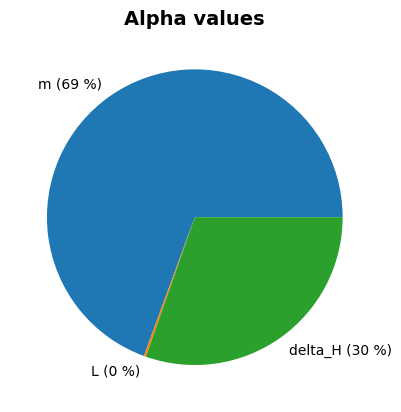

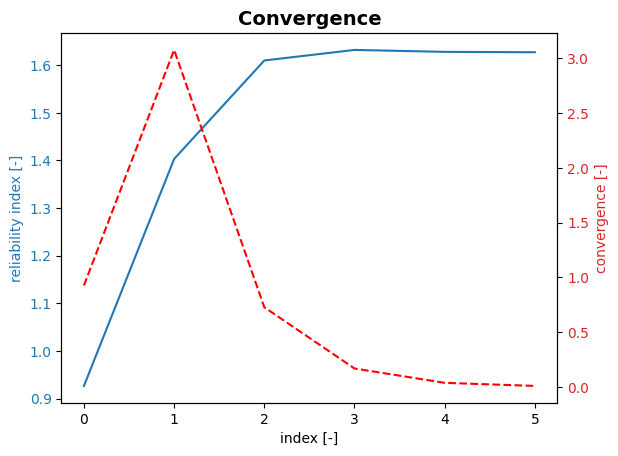

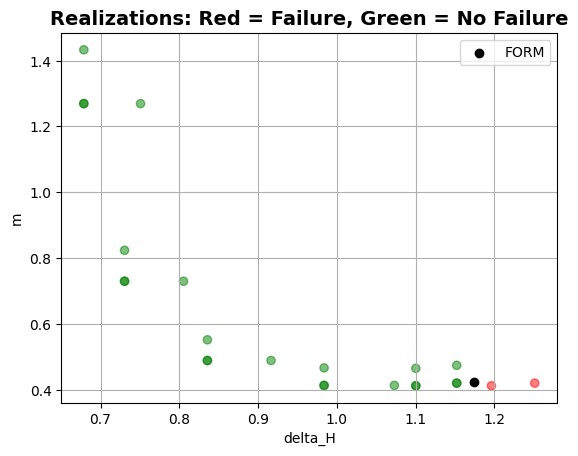

In [ ]:
project.settings.reliability_method = ReliabilityMethod.form
project.settings.relaxation_factor = 0.75
project.settings.maximum_iterations = 50
project.settings.epsilon_beta = 0.01
project.settings.save_realizations = True
project.settings.save_convergence = True

project.run()

project.design_point.print()
project.design_point.plot_alphas()
project.design_point.plot_convergence()
project.design_point.plot_realizations()

### Perform reliability calculations with Crude Monte Carlo

We now conduct the reliability analysis using the `crude_monte_carlo` method.

Reliability:
 Reliability index = 1.6439116355888135
 Probability of failure = 0.05009722817309914
 Convergence = 0.02499872064919814 (converged)
 Model runs = 30352
Alpha values:
 m: alpha = 0.8118988252730083, x = 0.4316074816304659
 L: alpha = 0.050757713310287604, x = 49.79139701123334
 c_creep: alpha = 0.0, x = 18.0
 delta_H: alpha = -0.5815874414564158, x = 1.2134481073274737



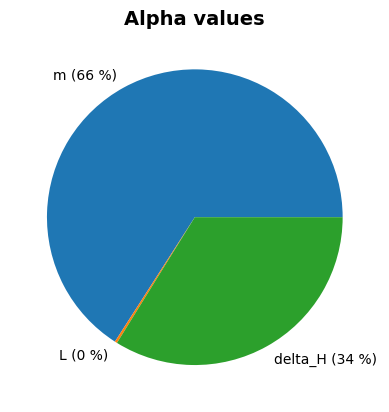

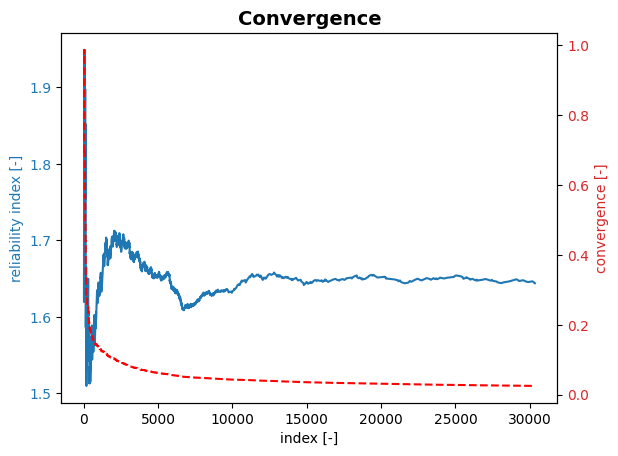

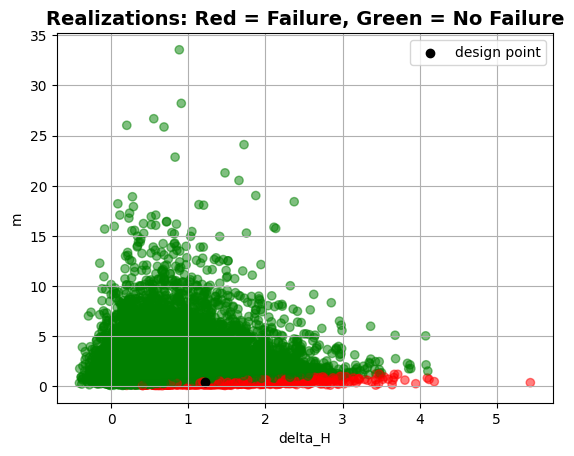

In [13]:
project.settings.reliability_method = ReliabilityMethod.crude_monte_carlo
project.settings.minimum_samples = 1000
project.settings.maximum_samples = 50000
project.settings.variation_coefficient = 0.025
project.settings.save_realizations = True
project.settings.save_convergence = True

project.run()

project.design_point.print()
project.design_point.plot_alphas()
project.design_point.plot_convergence()
project.design_point.plot_realizations()

### Perform reliability calculations with Numerical Integration
We now conduct the reliability analysis using the `numerical_integration` method.

Reliability:
 Reliability index = 1.6605659897086176
 Probability of failure = 0.04840032215651717
 Model runs = 50001
Alpha values:
 m: alpha = 0.8140532694038076, x = 0.4256829676038213
 L: alpha = 0.04915278049955129, x = 49.79594641100708
 c_creep: alpha = 0.0, x = 18.0
 delta_H: alpha = -0.5787065566780237, x = 1.2167100214923123



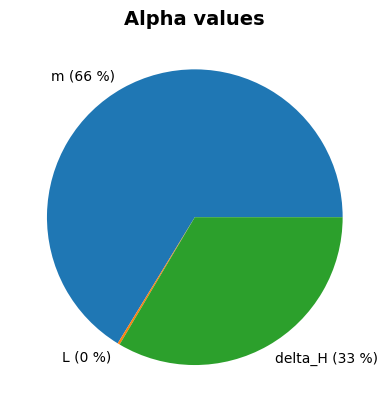

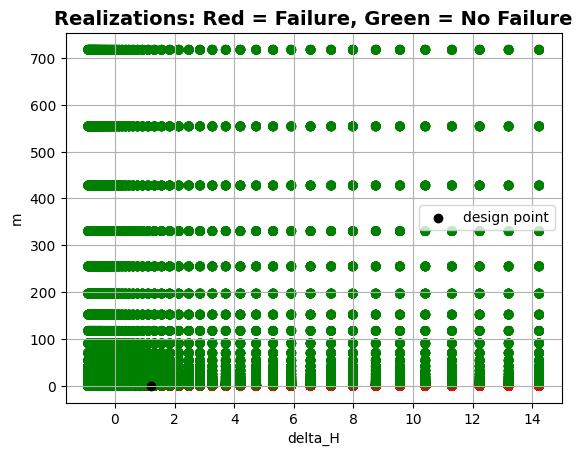

In [14]:
project.settings.reliability_method = ReliabilityMethod.numerical_integration
project.settings.stochast_settings["m"].intervals = 50
project.settings.stochast_settings["L"].intervals = 20
project.settings.stochast_settings["delta_H"].intervals = 50
project.settings.save_realizations = True

project.run()

project.design_point.print()
project.design_point.plot_alphas()
project.design_point.plot_realizations()